In [1]:
import torch
import numpy as np
import models,utils,camera
from datasets import CLEVR
import matplotlib.pyplot as plt
from tqdm import tqdm

path_train = r"C:\Users\Admin\Documents\Dataset\CLEVR_v1.0\CLEVR_v1.0\images\train"
path_test = r"C:\Users\Admin\Documents\Dataset\CLEVR_v1.0\CLEVR_v1.0\images\test"
BATCH_SIZE = 10
LEARNING_RATE = 0.0001
EPOCH = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


c:\Users\Admin\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#m = models.RayTransformer(d_encoder=64,d_object=32,channel_output=16,nb_object=20,num_transformer_layer=1,resolution_out=(28,28)).to(device)
m = torch.load('best.pth').to(device)
m.nb_object = 20
dataset_train = CLEVR(path_train)
loader = torch.utils.data.DataLoader(dataset_train,
                                    batch_size=BATCH_SIZE, shuffle=True,
                                    num_workers=4,drop_last = True)

dataset_test = CLEVR(path_test)

loader_test = torch.utils.data.DataLoader(dataset_train,
                                    batch_size=BATCH_SIZE,
                                    num_workers=4)

optimizer = torch.optim.Adam(list(m.parameters()),lr=LEARNING_RATE)
loss = torch.nn.MSELoss(reduce="mean")


c:\Users\Admin\anaconda3\envs\torch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [3]:
m.eval()
output= m(dataset_train.__getitem__(0).unsqueeze(0).to(device))
output.shape

torch.Size([1, 3, 112, 112])

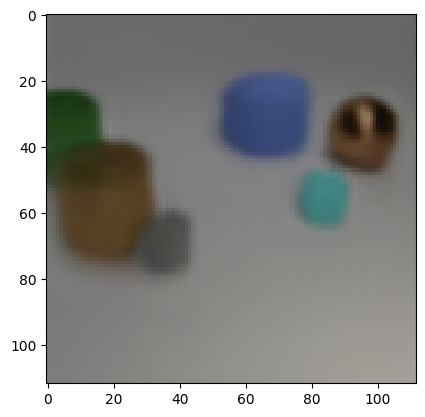

In [4]:
plt.imshow(output[0].permute(1,2,0).cpu().detach().numpy() )

In [ ]:
#torch.autograd.set_detect_anomaly(True)

In [12]:
m.train()
for epoch in range(100):
    mean = 0
    train_loop = tqdm(loader)
    for i,batch in enumerate(train_loop):
        batch= batch.to(device)
        l = loss(m(batch),batch)
        mean += float(l)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        train_loop.set_description(f"training {epoch+1}/{EPOCH}")
        train_loop.set_postfix(loss_task = float(l),tot_loss=mean/(i+1))


  0%|          | 0/7000 [00:00<?, ?it/s]

training 14/20:  61%|██████    | 4280/7000 [06:53<04:22, 10.36it/s, loss_task=0.00692, tot_loss=0.00656]


KeyboardInterrupt: 

In [5]:
pytorch_total_params = sum(p.numel() for p in m.parameters())
pytorch_total_params

671854

In [20]:
loader_test = torch.utils.data.DataLoader(dataset_test,
                                    batch_size=BATCH_SIZE,
                                    num_workers=4)

In [40]:

train_loop = tqdm(loader_test)
m.eval()
mean = 0
for i,batch in enumerate(train_loop):
    batch= batch.to(device)
    with torch.no_grad():
        l = loss(m(batch),batch)
    
    mean += float(l)
    
    train_loop.set_description(f"Test")
    train_loop.set_postfix(loss_task = float(l),tot_loss=mean/(i+1))

  0%|          | 0/750 [00:13<?, ?it/s]


KeyboardInterrupt: 

In [47]:
torch.save(m,'model_4.pth')

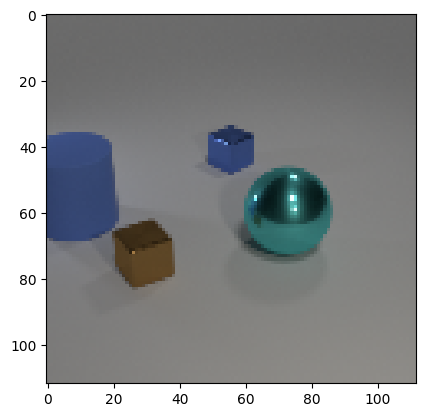

In [13]:
id = 3
plt.imshow(dataset_test.__getitem__(id).permute(1,2,0) )


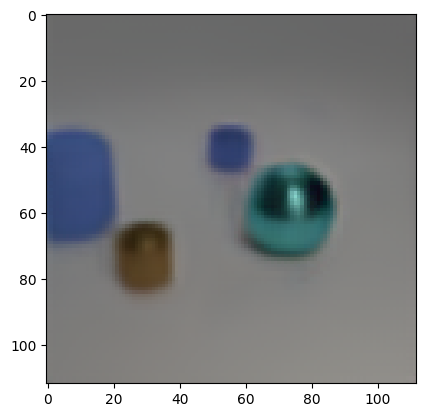

In [14]:
m.eval()
input = dataset_test.__getitem__(id).unsqueeze(0).to(device)
output = m.output(input)
plt.imshow(output['render'][0].permute(1,2,0).cpu().detach().numpy() )


In [15]:
import torchvision
torchvision.utils.save_image(output['render'][0],'reconstruction_1.png')

In [16]:
import torchvision
torchvision.utils.save_image(dataset_test.__getitem__(id),'gt_1.png')

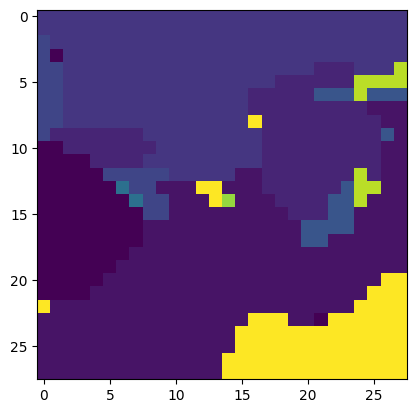

In [15]:
plt.imshow(output['ponderation'][0].max(-1)[1].cpu().detach().numpy() )

In [9]:
ra = torch.rand(20-1,3)
ra = ra/(ra**2).sum(-1,keepdim=True).sqrt()
color = torch.concat([torch.zeros(1,3),ra],dim=0)

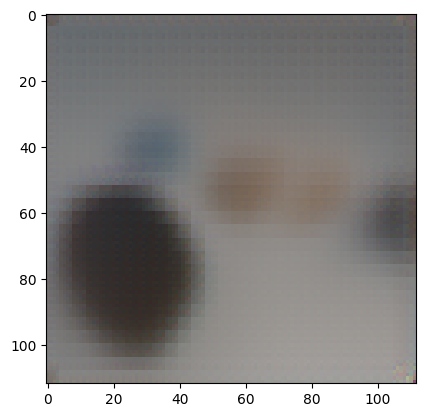

In [20]:
input = dataset_test.__getitem__(id).unsqueeze(0).to(device)
id_object = torch.IntTensor([3,4,5,6,7,8,9,10,11,12,13,14])
output = m.output(input,object_pos=torch.Tensor([0,0,0,0,0,0]),keep_object=id_object,color=color)
plt.imshow(output['render'][0].permute(1,2,0).cpu().detach().numpy() )

In [36]:
output['x_spatial'][0,:,6:]

tensor([[-0.4397, -2.0541, 13.5936],
        [-0.5442,  2.4469,  8.9939],
        [-0.3502, -3.3297, 10.0557]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [100]:
import torchvision
nb_image = [50,30,30,30,30,40]
traj = torch.Tensor([[0,0,0,0,0,0],[0.2,0.,0,1,0,0],[0,0.,0,0,1,0],[0,0.,0,0,0,0],[0,0,3.14,0,0,0],[0,0,2*3.14,0,0,0],[0,0,2*3.14,0,0,-5]])
resize = torchvision.transforms.Resize((112,112))
video = torch.zeros(sum(nb_image),3,112,112+56)
image_id=0
for i,nb in tqdm(enumerate(nb_image)):
    for j in range(nb):
        coef = j/nb
        pos = (1-coef)*traj[i]+coef*traj[i+1]
        remove = torch.zeros(20)
        with torch.no_grad():
            output_image = m.output(input,object_pos=pos,color=color)
        video[image_id,:,:,:112] = output_image['render']
        video[image_id,:,:56,112:112+56] = output_image['segment_soft']
        video[image_id,:,56:,112:112+56] = output_image['depth_sum'].repeat(3,1,1)
        image_id+=1
video[:,:,56:,112:112+56] -= video[:,:,56:,112:112+56].min()
video[:,:,56:,112:112+56] /= video[:,:,56:,112:112+56].max()
video = video


0it [00:00, ?it/s]

6it [00:02,  2.26it/s]


In [101]:
from torchvision.io import write_video
write_video('test_2.mp4',255*video.permute(0,2,3,1),30)

In [92]:
import torchvision
nb_image = [50,30,30,30,30,40]
traj = torch.Tensor([[0,0,0,0,0,0],[0.2,0.,0,1,0,0],[0,0.,0,0,1,0],[0,0.,0,0,0,0],[0,0,3.14,0,0,0],[0,0,2*3.14,0,0,0],[0,0,2*3.14,0,0,-5]])
resize = torchvision.transforms.Resize((112,112))
video = torch.zeros(sum(nb_image),3,112*2,112*2)
image_id=0
for i,nb in tqdm(enumerate(nb_image)):
    for j in range(nb):
        coef = j/nb
        pos = (1-coef)*traj[i]+coef*traj[i+1]
        remove = torch.zeros(20)
        with torch.no_grad():
            video[image_id,:,:112,:112] =  m.output(input,object_pos=pos,keep_object=torch.IntTensor([0,6,7,8,9,10,11,12,13]),color=color)['render']
            video[image_id,:,:112,112:2*112] = m.output(input,object_pos=pos,keep_object=torch.IntTensor([0,7,8,9,10,11,12,13]),color=color)['render']
            video[image_id,:,112:2*112,:112] = m.output(input,object_pos=pos,keep_object=torch.IntTensor([0,6,9,10,11,12,13]),color=color)['render']
            video[image_id,:,112:2*112,112:2*112] = m.output(input,object_pos=pos,keep_object=torch.IntTensor([0,6,7,8]),color=color)['render']
        image_id+=1

video = video

0it [00:00, ?it/s]

6it [00:09,  1.52s/it]


In [93]:
from torchvision.io import write_video
write_video('test_remove.mp4',255*video.permute(0,2,3,1),30)

In [90]:
import torchvision
nb_image = [50,30,30,30,30,40]
traj = torch.Tensor([[0,0,0,0,0,0],[0.2,0.,0,1,0,0],[0,0.,0,0,1,0],[0,0.,0,0,0,0],[0,0,3.14,0,0,0],[0,0,2*3.14,0,0,0],[0,0,2*3.14,0,0,-5]])
resize = torchvision.transforms.Resize((112,112))
video = torch.zeros(sum(nb_image),3,112,112*3)
image_id=0
for i,nb in tqdm(enumerate(nb_image)):
    for j in range(nb):
        coef = j/nb
        pos = (1-coef)*traj[i]+coef*traj[i+1]
        pos = pos.unsqueeze(0).repeat(20,1)
        remove = torch.zeros(20)
        with torch.no_grad():
            video[image_id,:,:,:112] =  m.output(input,object_pos=pos,keep_object=torch.IntTensor([0,6,10,11,12]),color=color)['render']
            pos[6] += torch.Tensor([0,0,0,2,0,0])
            video[image_id,:,:,112:2*112] = m.output(input,object_pos=pos,keep_object=torch.IntTensor([0,6,10,11,12]),color=color)['render']
            pos[6] += torch.Tensor([0,0,0,-2,-2,0])
            video[image_id,:,:,2*112:3*112] = m.output(input,object_pos=pos,keep_object=torch.IntTensor([0,6,10,11,12]),color=color)['render']
            
        image_id+=1

video = video

6it [00:06,  1.13s/it]


In [91]:
from torchvision.io import write_video
write_video('test_mov.mp4',255*video.permute(0,2,3,1),30)

In [20]:
np.cos(3.14)

-0.9999987317275395

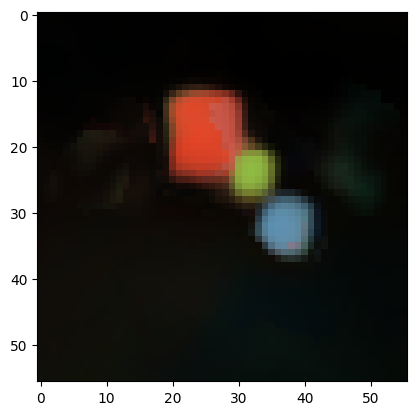

In [9]:
plt.imshow(output['segment_soft'][0].permute(1,2,0).cpu().detach().numpy() )

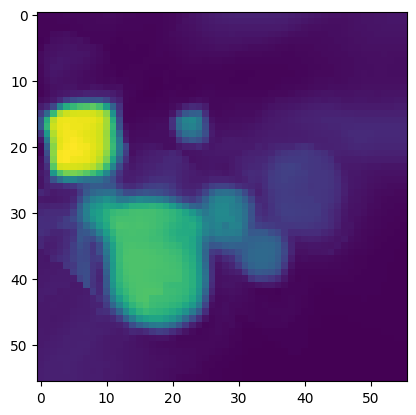

In [51]:
plt.imshow(output['segment_soft'][0].cpu().detach().numpy() )

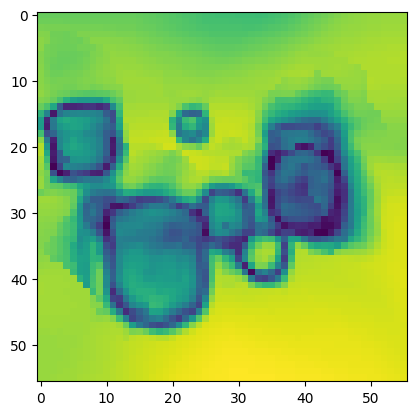

In [52]:
plt.imshow(output['ponderation_max'][0].cpu().detach().numpy() )

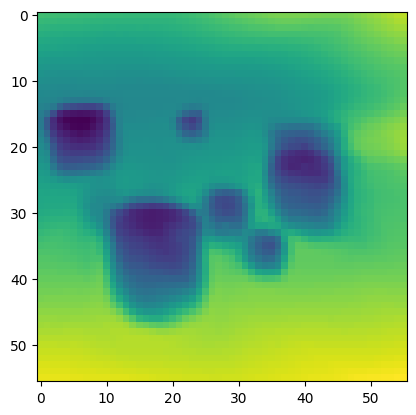

In [53]:
plt.imshow(output['depth_sum'][0].cpu().detach().numpy())

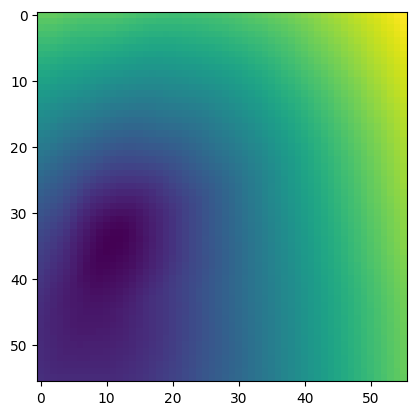

In [12]:
o=11
plt.imshow(output['depth'][0][:,:,o].cpu().detach().numpy())

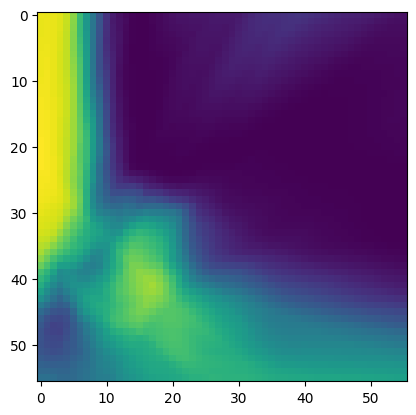

In [13]:
plt.imshow((1-output['transmitance'][0])[:,:,o].cpu().detach().numpy())

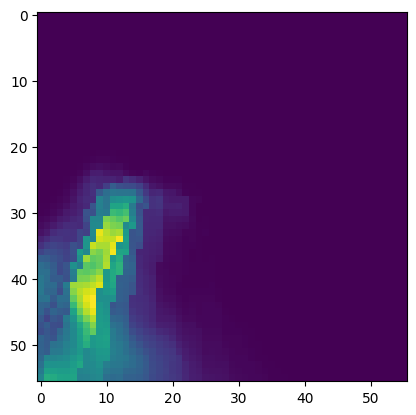

In [14]:
plt.imshow(output['ponderation'][0][:,:,o].cpu().detach().numpy())

In [14]:
output['ponderation'][0,0,0]

tensor([8.8882e-01, 1.4223e-02, 1.8033e-03, 7.5578e-04, 1.0468e-03, 1.0435e-04,
        9.9327e-04, 8.7190e-05, 3.4215e-04, 4.3048e-04, 3.2166e-05, 8.0220e-04,
        7.4524e-04, 1.9832e-03, 1.7724e-03, 1.0593e-03, 4.3658e-04, 0.0000e+00,
        2.1045e-05, 3.5639e-07], device='cuda:0', grad_fn=<SelectBackward0>)

In [19]:
output['ponderation'][0,0,0].sum()

tensor(0.9155, device='cuda:0', grad_fn=<SumBackward0>)

In [20]:
output['depth'][0,0,0]

tensor([-0.6306,  3.6555,  6.5255,  8.4990,  8.2610,  9.8036, 11.1251,  9.1372,
         8.8455,  8.5675,  3.5445,  7.3202,  7.6774,  6.3108,  4.5068,  2.4981,
        -0.2395, -0.1902, -0.2405, -0.2221], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [ ]:
torch.sigmoid(-torch.ones(1))

tensor([0.2689])

In [24]:
points = output['x_spatial'][0,:,6:].cpu().detach()
points


tensor([[-0.5422,  0.8109, -3.6128],
        [-1.4877,  1.3524, -5.9697],
        [-1.5253,  1.4756, -6.8575],
        [-1.5197,  1.5816, -7.4141],
        [-1.6428,  1.6496, -7.4058],
        [-0.6165,  0.6475, -7.4025],
        [-0.4975,  0.6231, -7.5789],
        [-1.1116,  0.2372, -7.8564],
        [-1.6542, -0.1623, -8.5187],
        [-1.6841, -0.2852, -8.3903],
        [-3.0550, -0.5971, -7.3695],
        [-0.5711, -1.6437, -7.2811],
        [-0.1172, -1.8892, -7.4069],
        [-0.0993, -2.0641, -7.1415],
        [-0.5981, -2.2181, -6.6799],
        [-1.0762, -2.7676, -6.5846],
        [-1.5708, -2.7031, -6.1470],
        [-1.4258, -2.7238, -6.3355],
        [-1.2605, -2.7467, -6.2318],
        [-1.2305, -2.7698, -6.1628]])

In [25]:
output['x_spatial'][0].cpu().detach()

tensor([[-4.7386e-02,  2.1155e+00,  1.7545e+00, -1.3880e+00,  2.5357e+00,
         -4.6547e-01, -5.4221e-01,  8.1090e-01, -3.6128e+00],
        [-8.3091e-01,  3.5263e+00,  1.7823e+00, -8.4409e-01,  3.3087e+00,
         -1.9459e+00, -1.4877e+00,  1.3524e+00, -5.9697e+00],
        [-1.1400e+00,  3.8788e+00,  1.4186e+00, -4.1252e-01,  3.2094e+00,
         -2.4741e+00, -1.5253e+00,  1.4756e+00, -6.8575e+00],
        [-1.2826e+00,  3.9290e+00,  1.0507e+00, -3.2937e-02,  2.9464e+00,
         -2.7539e+00, -1.5197e+00,  1.5816e+00, -7.4141e+00],
        [-1.2296e+00,  3.9685e+00,  1.0417e+00, -6.7574e-02,  2.7165e+00,
         -2.6438e+00, -1.6428e+00,  1.6496e+00, -7.4058e+00],
        [-1.1753e+00,  3.7233e+00,  4.4262e-01,  5.9014e-01,  1.8764e+00,
         -2.0810e+00, -6.1652e-01,  6.4753e-01, -7.4025e+00],
        [-1.1007e+00,  3.5852e+00,  1.0389e-01,  9.4563e-01,  1.6485e+00,
         -2.2430e+00, -4.9749e-01,  6.2313e-01, -7.5789e+00],
        [-1.4180e+00,  4.7158e+00,  3.4490e-01, 

In [26]:
points_n = points/((points**2).sum(-1,keepdim = True)).sqrt()
points_n

tensor([[-0.1449,  0.2167, -0.9654],
        [-0.2362,  0.2147, -0.9477],
        [-0.2125,  0.2056, -0.9553],
        [-0.1966,  0.2046, -0.9589],
        [-0.2116,  0.2125, -0.9540],
        [-0.0827,  0.0868, -0.9928],
        [-0.0653,  0.0818, -0.9945],
        [-0.1400,  0.0299, -0.9897],
        [-0.1906, -0.0187, -0.9815],
        [-0.1967, -0.0333, -0.9799],
        [-0.3819, -0.0746, -0.9212],
        [-0.0763, -0.2196, -0.9726],
        [-0.0153, -0.2471, -0.9689],
        [-0.0134, -0.2776, -0.9606],
        [-0.0847, -0.3140, -0.9456],
        [-0.1490, -0.3832, -0.9116],
        [-0.2278, -0.3920, -0.8913],
        [-0.2025, -0.3868, -0.8997],
        [-0.1820, -0.3966, -0.8998],
        [-0.1792, -0.4033, -0.8974]])

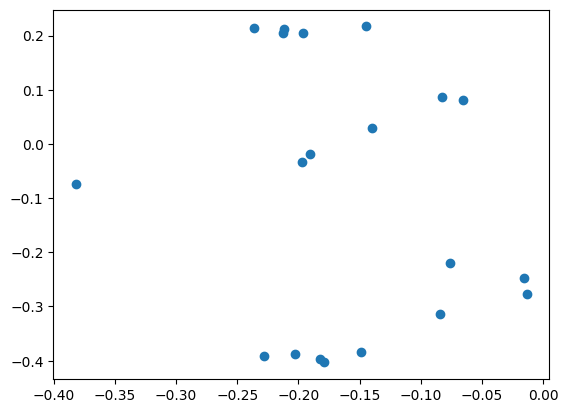

In [28]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(points_n[:,0].numpy(),points_n[:,1].numpy())

In [ ]:
models.build_grid((8,8))

tensor([[[[0.0000, 0.0000, 1.0000, 1.0000],
          [0.0000, 0.1429, 1.0000, 0.8571],
          [0.0000, 0.2857, 1.0000, 0.7143],
          [0.0000, 0.4286, 1.0000, 0.5714],
          [0.0000, 0.5714, 1.0000, 0.4286],
          [0.0000, 0.7143, 1.0000, 0.2857],
          [0.0000, 0.8571, 1.0000, 0.1429],
          [0.0000, 1.0000, 1.0000, 0.0000]],

         [[0.1429, 0.0000, 0.8571, 1.0000],
          [0.1429, 0.1429, 0.8571, 0.8571],
          [0.1429, 0.2857, 0.8571, 0.7143],
          [0.1429, 0.4286, 0.8571, 0.5714],
          [0.1429, 0.5714, 0.8571, 0.4286],
          [0.1429, 0.7143, 0.8571, 0.2857],
          [0.1429, 0.8571, 0.8571, 0.1429],
          [0.1429, 1.0000, 0.8571, 0.0000]],

         [[0.2857, 0.0000, 0.7143, 1.0000],
          [0.2857, 0.1429, 0.7143, 0.8571],
          [0.2857, 0.2857, 0.7143, 0.7143],
          [0.2857, 0.4286, 0.7143, 0.5714],
          [0.2857, 0.5714, 0.7143, 0.4286],
          [0.2857, 0.7143, 0.7143, 0.2857],
          [0.2857, 0.8571, 0

In [ ]:
x = m.imageEncoder(input)
b,w,h,d= x.shape
x = x.reshape(b,-1,d)
x = m.TransformerEncoder(x) #(b,e,32)
x

tensor([[[ 0.0499, -1.5223,  0.3560,  ...,  0.7360, -1.4275,  0.4444],
         [ 0.0226, -1.7492,  0.2152,  ...,  0.7799, -1.5081,  0.9824],
         [ 0.0730, -1.8729,  0.0093,  ...,  0.6718, -1.3421,  1.5269],
         ...,
         [ 0.0513,  0.2340,  1.2662,  ...,  1.1317, -1.5730, -0.4599],
         [ 0.5735, -0.0633,  1.0682,  ...,  1.2832, -1.7290, -0.3670],
         [ 0.9021, -0.2718,  0.8409,  ...,  1.4199, -1.7964, -0.1517]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [ ]:
x

tensor([[[ 0.0499, -1.5223,  0.3560,  ...,  0.7360, -1.4275,  0.4444],
         [ 0.0226, -1.7492,  0.2152,  ...,  0.7799, -1.5081,  0.9824],
         [ 0.0730, -1.8729,  0.0093,  ...,  0.6718, -1.3421,  1.5269],
         ...,
         [ 0.0513,  0.2340,  1.2662,  ...,  1.1317, -1.5730, -0.4599],
         [ 0.5735, -0.0633,  1.0682,  ...,  1.2832, -1.7290, -0.3670],
         [ 0.9021, -0.2718,  0.8409,  ...,  1.4199, -1.7964, -0.1517]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [ ]:
import torch
coef = torch.Tensor([1,0.6,0.4,0.4,0.6,1,1,1,1,1,0.4,0.6,1,0.4,0.6,1,0.8,0.2,0.6,0.4,0.6,0.4,0.8,0.2,1,1,1,1,1])
note = torch.Tensor([18,18,13,15,8.5,15,17.5,14.5,17.25,13.5,14.5,14,16.7,11.5,11.5,14,13,10,16,13,14,16,19,15,14.5,15.1,18,13.5,17])

In [ ]:
(note*coef).sum()/coef.sum()

tensor(15.1214)